In [ ]:
# Importer les bibliothèques nécessaires
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [2]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Afficher la distribution de la classe cible
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [6]:
# Visualiser la distribution de la classe cible
from sklearn.model_selection import train_test_split
X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [7]:
# Standardiser les features 'Time' et 'Amount'
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train[['Time', 'Amount']] = scaler.fit_transform(X_train[['Time', 'Amount']])
X_test[['Time', 'Amount']] = scaler.transform(X_test[['Time', 'Amount']])

In [8]:
# Entraîner un modèle de régression logistique avec class_weight='balanced'
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)

# Predictions at default threshold (0.5)
predictions = model.predict(X_test)

# Probability estimates for each class
prob = model.predict_proba(X_test)

print(f"Model trained successfully on {X_train.shape[0]:,} samples")
print(f"Default Accuracy: {accuracy_score(y_test, predictions):.4f}")

Model trained successfully on 199,364 samples
Default Accuracy: 0.9787


  EVALUATION AT DEFAULT THRESHOLD (0.5)

  Accuracy : 0.9787
  ROC-AUC  : 0.9679

              precision    recall  f1-score   support

  Legitimate       1.00      0.98      0.99     85295
       Fraud       0.07      0.88      0.12       148

    accuracy                           0.98     85443
   macro avg       0.53      0.93      0.56     85443
weighted avg       1.00      0.98      0.99     85443



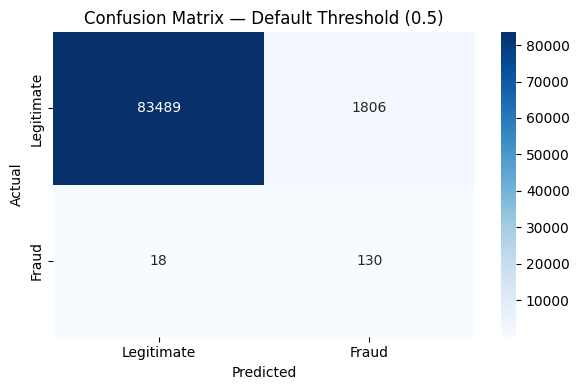

In [9]:
# Evaluation at Default Threshold (0.5)
from sklearn.metrics import roc_auc_score

# --- Evaluation at Default Threshold (0.5) ---
print("=" * 55)
print("  EVALUATION AT DEFAULT THRESHOLD (0.5)")
print("=" * 55)
print(f"\n  Accuracy : {accuracy_score(y_test, predictions):.4f}")
print(f"  ROC-AUC  : {roc_auc_score(y_test, prob[:, 1]):.4f}")
print(f"\n{classification_report(y_test, predictions, target_names=['Legitimate', 'Fraud'])}")

# --- Confusion Matrix ---
fig, ax = plt.subplots(figsize=(6, 4))
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Fraud'],
            yticklabels=['Legitimate', 'Fraud'], ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix — Default Threshold (0.5)')
plt.tight_layout()
plt.show()

In [10]:
# Extraire les probabilités de la classe positive (fraude)
y_pred_proba = prob[:, 1]

# --- Impact of Different Thresholds on Fraud Detection Performance ---
thresholds_to_test = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

print(f"{'Threshold':>10} | {'Precision':>10} | {'Recall':>10} | {'F1-Score':>10} | {'Fraud Caught':>13} | {'False Alarms':>13}")
print("-" * 85)

for t in thresholds_to_test:
    preds_t = (y_pred_proba >= t).astype(int)
    report = classification_report(y_test, preds_t, output_dict=True, zero_division=0)
    fraud_caught = preds_t[y_test == 1].sum()
    false_alarms = preds_t[y_test == 0].sum()
    total_fraud = y_test.sum()
    print(f"{t:>10.1f} | {report['1']['precision']:>10.4f} | {report['1']['recall']:>10.4f} | "
          f"{report['1']['f1-score']:>10.4f} | {fraud_caught:>6d}/{total_fraud:<6d} | {false_alarms:>13,}")

 Threshold |  Precision |     Recall |   F1-Score |  Fraud Caught |  False Alarms
-------------------------------------------------------------------------------------
       0.1 |     0.0099 |     0.9392 |     0.0195 |    139/148    |        13,948
       0.2 |     0.0194 |     0.9122 |     0.0380 |    135/148    |         6,817
       0.3 |     0.0314 |     0.8986 |     0.0607 |    133/148    |         4,100
       0.4 |     0.0467 |     0.8784 |     0.0886 |    130/148    |         2,656
       0.5 |     0.0671 |     0.8784 |     0.1248 |    130/148    |         1,806
       0.6 |     0.0951 |     0.8649 |     0.1714 |    128/148    |         1,218
       0.7 |     0.1331 |     0.8581 |     0.2305 |    127/148    |           827
       0.8 |     0.1805 |     0.8514 |     0.2979 |    126/148    |           572


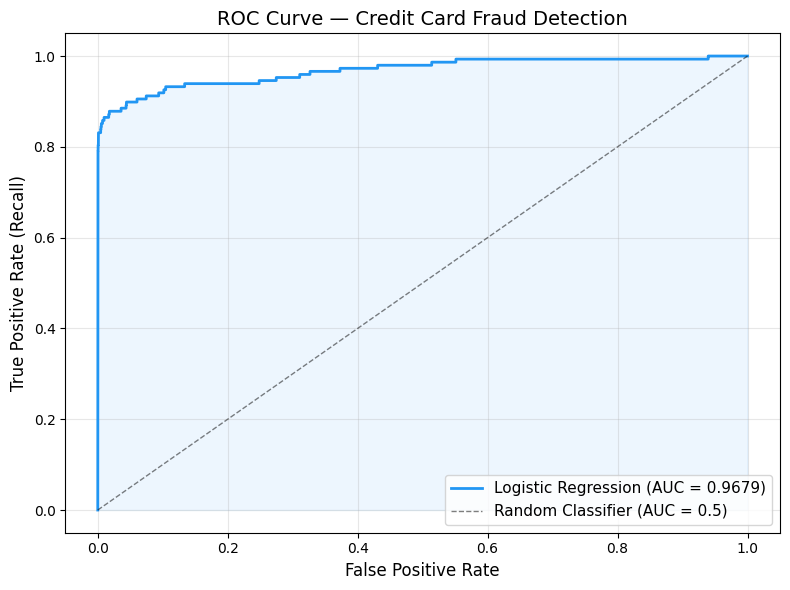


ROC-AUC Score: 0.9679


In [11]:
from sklearn.metrics import roc_curve

# Compute ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_test, prob[:, 1])
auc_score = roc_auc_score(y_test, prob[:, 1])

# --- Plot ROC Curve ---
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, color='#2196F3', lw=2, label=f'Logistic Regression (AUC = {auc_score:.4f})')
ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5, label='Random Classifier (AUC = 0.5)')
ax.fill_between(fpr, tpr, alpha=0.08, color='#2196F3')

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate (Recall)', fontsize=12)
ax.set_title('ROC Curve — Credit Card Fraud Detection', fontsize=14)
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nROC-AUC Score: {auc_score:.4f}")

In [12]:
# --- Find Optimal Threshold with FPR ≤ 5% Business Constraint ---
fpr_limit = 0.05
valid_indices = np.where(fpr <= fpr_limit)[0]
index = valid_indices[-1]
optimal_threshold = roc_thresholds[index]

print(f"Business Constraint   : FPR ≤ {fpr_limit:.0%}")
print(f"Optimal Threshold     : {optimal_threshold:.4f}")
print(f"True Positive Rate    : {tpr[index]:.4f}  (fraud cases caught)")
print(f"False Positive Rate   : {fpr[index]:.4f}  (legitimate customers affected)")

Business Constraint   : FPR ≤ 5%
Optimal Threshold     : 0.3181
True Positive Rate    : 0.8986  (fraud cases caught)
False Positive Rate   : 0.0441  (legitimate customers affected)


  EVALUATION AT ROC-OPTIMAL THRESHOLD (0.3181)

              precision    recall  f1-score   support

  Legitimate       1.00      0.96      0.98     85295
       Fraud       0.03      0.90      0.07       148

    accuracy                           0.96     85443
   macro avg       0.52      0.93      0.52     85443
weighted avg       1.00      0.96      0.98     85443



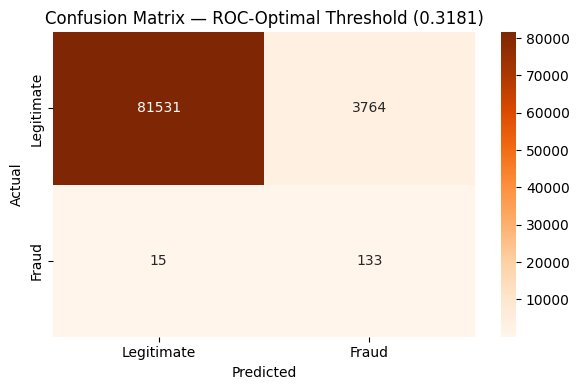

In [13]:
# --- Evaluate Model at ROC-Optimal Threshold ---
predictions_roc = (y_pred_proba >= optimal_threshold).astype(int)

print("=" * 55)
print(f"  EVALUATION AT ROC-OPTIMAL THRESHOLD ({optimal_threshold:.4f})")
print("=" * 55)
print(f"\n{classification_report(y_test, predictions_roc, target_names=['Legitimate', 'Fraud'])}")

fig, ax = plt.subplots(figsize=(6, 4))
cm_roc = confusion_matrix(y_test, predictions_roc)
sns.heatmap(cm_roc, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Legitimate', 'Fraud'],
            yticklabels=['Legitimate', 'Fraud'], ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'Confusion Matrix — ROC-Optimal Threshold ({optimal_threshold:.4f})')
plt.tight_layout()
plt.show()

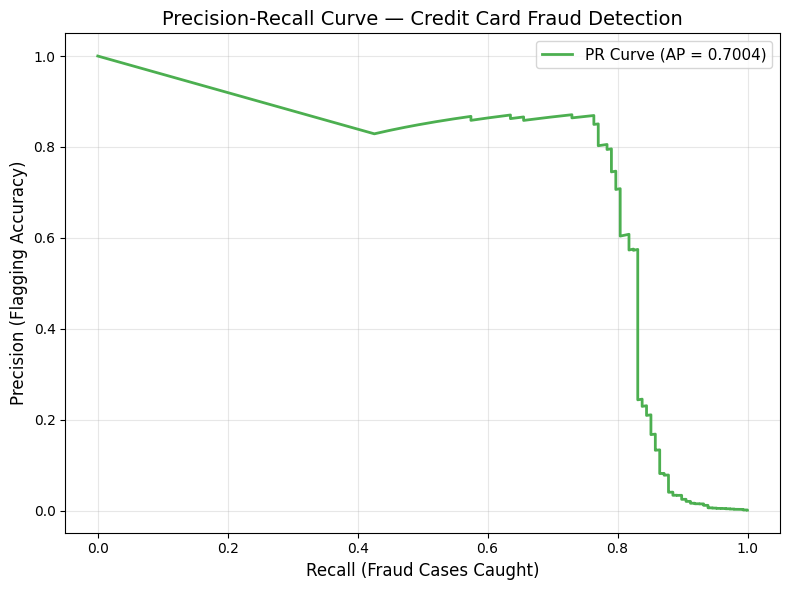


Average Precision (AP): 0.7004


In [14]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute Precision-Recall Curve
precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test, prob[:, 1])
avg_precision = average_precision_score(y_test, prob[:, 1])

# --- Plot Precision-Recall Curve ---
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(recall_curve, precision_curve, color='#4CAF50', lw=2,
        label=f'PR Curve (AP = {avg_precision:.4f})')
ax.set_xlabel('Recall (Fraud Cases Caught)', fontsize=12)
ax.set_ylabel('Precision (Flagging Accuracy)', fontsize=12)
ax.set_title('Precision-Recall Curve — Credit Card Fraud Detection', fontsize=14)
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nAverage Precision (AP): {avg_precision:.4f}")

In [15]:
# --- Find Precision-Recall Equilibrium Point ---
metric_df = pd.DataFrame({
    'threshold': pr_thresholds,
    'precision': precision_curve[:-1],
    'recall': recall_curve[:-1]
})

# Closest point where Precision ≈ Recall
metric_df['gap'] = abs(metric_df['precision'] - metric_df['recall'])
equilibrium_row = metric_df.loc[metric_df['gap'].idxmin()]

print("Precision-Recall Equilibrium Point:")
print(f"  Threshold : {equilibrium_row['threshold']:.4f}")
print(f"  Precision : {equilibrium_row['precision']:.4f}")
print(f"  Recall    : {equilibrium_row['recall']:.4f}")
print(f"  Gap       : {equilibrium_row['gap']:.6f}")

Precision-Recall Equilibrium Point:
  Threshold : 1.0000
  Precision : 0.7905
  Recall    : 0.7905
  Gap       : 0.000000


In [16]:
# --- Side-by-Side Comparison of All Threshold Strategies ---
strategies = {
    'Default (0.50)': 0.5,
    f'ROC-Optimal ({optimal_threshold:.4f})': optimal_threshold,
    f'PR-Equilibrium ({equilibrium_row["threshold"]:.4f})': equilibrium_row['threshold']
}

comparison_results = []
for name, thresh in strategies.items():
    preds = (y_pred_proba >= thresh).astype(int)
    report = classification_report(y_test, preds, output_dict=True, zero_division=0)
    cm_temp = confusion_matrix(y_test, preds)
    comparison_results.append({
        'Strategy': name,
        'Threshold': round(thresh, 4),
        'Precision (Fraud)': round(report['1']['precision'], 4),
        'Recall (Fraud)': round(report['1']['recall'], 4),
        'F1 (Fraud)': round(report['1']['f1-score'], 4),
        'False Positives': int(cm_temp[0][1]),
        'Missed Fraud (FN)': int(cm_temp[1][0])
    })

comparison_df = pd.DataFrame(comparison_results)
comparison_df.set_index('Strategy', inplace=True)
comparison_df

,Threshold,Precision (Fraud),Recall (Fraud),F1 (Fraud),False Positives,Missed Fraud (FN)
Strategy,,,,,,
Default (0.50),0.5000,0.0671,0.8784,0.1248,1806,18
ROC-Optimal (0.3181),0.3181,0.0341,0.8986,0.0658,3764,15
PR-Equilibrium (1.0000),1.0000,0.7905,0.7905,0.7905,31,31


In [17]:
# Sauvegarde du meilleur modèle et des résultats d'évaluation
import joblib
best_model_info = {
    'model': model,
    'scaler': scaler,
    'optimal_threshold': optimal_threshold,
    'evaluation': {
        'default_threshold': {
            'accuracy': accuracy_score(y_test, predictions),
            'roc_auc': roc_auc_score(y_test, prob[:, 1]),
            'classification_report': classification_report(y_test, predictions, target_names=['Legitimate', 'Fraud'])
        },
        'roc_optimal_threshold': {
            'accuracy': accuracy_score(y_test, predictions_roc),
            'classification_report': classification_report(y_test, predictions_roc, target_names=['Legitimate', 'Fraud'])
        }
    }
}
joblib.dump(best_model_info, 'best_credit_card_fraud_model.pkl')
print("\nBest model and evaluation results saved to 'best_credit_card_fraud_model.pkl'")


Best model and evaluation results saved to 'best_credit_card_fraud_model.pkl'
